# The Split-Apply-Combine Paradigm

Now we will discuss ways to summarize the relationship between a categorical variable and a quantitative variable. We will see how the "split-apply-combine" paradigm provides a useful way of thinking about and performing operations by groups.

We'll use the Ames housing data set as an example.

In [1]:
import pandas as pd

In [2]:
df_ames = pd.read_csv("https://raw.githubusercontent.com/kevindavisross/data301/main/data/AmesHousing.txt", sep="\t")
df_ames

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


We'll first consider the sale price ("SalePrice", quantitative) and the building type variables ("Bldg Type", categorical). We could find the categories of "Bldg Type" using `value_counts` or with `unique` as below.

In [3]:
df_ames["Bldg Type"].unique()

array(['1Fam', 'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'], dtype=object)

Suppose we want to view the (conditional) distribution of sale price given each building type. First, just consider "1Fam" (single-family) homes. We could could create a subset of the data frame consisting of "1Fam" (single-family) homes, then create a histogram of sale price for this subset.

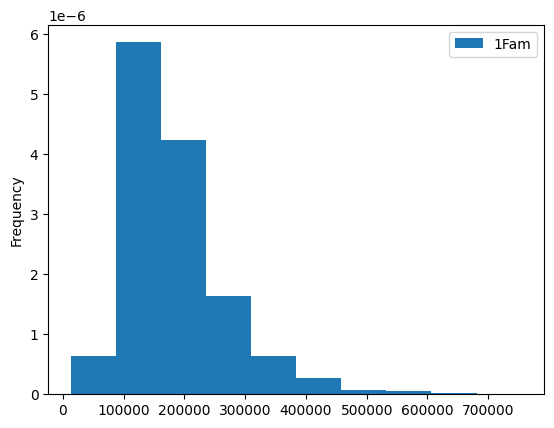

In [4]:
df_ames[df_ames["Bldg Type"] == "1Fam"]["SalePrice"].plot.hist(
        label="1Fam",
        density=True,
        legend=True
);

If we want to view the (conditional) distribution of sale price given each building type, we could repeat the above process for each building type. The code below accomplishes this by creating a `for` loop which iterates over the categories of "Bldg Type". Notice how the index of the loop, `bldg_type`, replaces "1Fam" in the code above. (Don't worry; we'll see an easier way to do this very soon!)

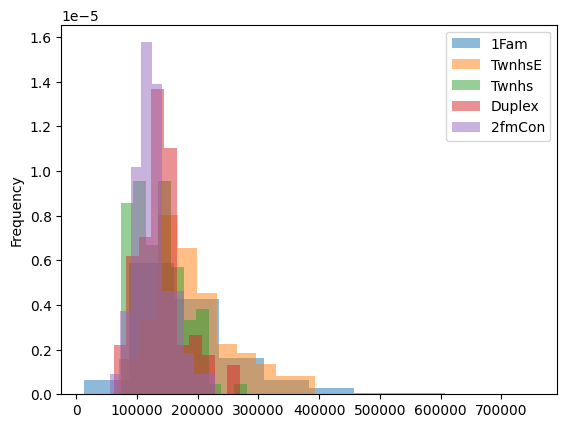

In [5]:
for bldg_type in df_ames["Bldg Type"].unique():
    df_ames[df_ames["Bldg Type"] == bldg_type]["SalePrice"].plot.hist(
        label=bldg_type,
        density=True,
        alpha=0.5,
        legend=True
    );

If we want to compare the centers of the distributions we could find the conditional median (or mean) for each building type. The conditional medians can be visualized using a bar chart. We manually construct the `pandas` `Series` for making the bar chart. (Again, we'll see an easier way to do this very soon!)

In [6]:
median_sale_price = pd.Series()

for bldg_type in df_ames["Bldg Type"].unique():
    median_sale_price[bldg_type] = df_ames[df_ames["Bldg Type"] == bldg_type]["SalePrice"].median()

median_sale_price

1Fam      165000.0
TwnhsE    180000.0
Twnhs     130000.0
Duplex    136905.0
2fmCon    122250.0
dtype: float64

<Axes: >

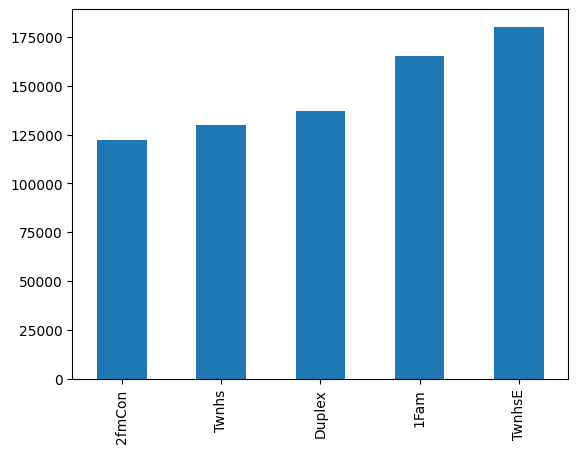

In [7]:
median_sale_price.sort_values().plot.bar()

The code above does its job, but it is inefficient and repetitive, and not the easiest to read. Fortunately, there is a better way!

## Split-Apply-Combine Strategy

The problem of calculating the median sale price for each building type is an example of a problem that can be solved using the _split-apply-combine strategy_. The key insight here is that many data analyses follow the same basic pattern:

- First, a data set is _split_ into several subsets based on some variable.
- Next, some analysis is _applied_ to each subset.
- Finally, the results from each analysis are _combined_.

The three steps are diagrammed in the figure below:

![](https://github.com/dlsun/pods/blob/master/03-Quantitative-Data/split_apply_combine.png?raw=1) [source](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb)

Applying this strategy to the working example above, we should first _split_ up the Ames data according to the building type, _apply_ the median sale price to each subset, and finally _combine_ the results into one `Series`.

[_Note:_ The term "split-apply-combine" was coined by Hadley Wickham in [a 2011 paper](https://www.jstatsoft.org/article/view/v040i01), but the idea is not new. If you happen to know SQL or MapReduce, it should already be familiar to you.]

## Split-Apply-Combine in `pandas`: the `.groupby()` method

To implement the split-apply-combine strategy in `pandas`, we use the `.groupby()` method. First, we specify one or more variables to split on in the argument to `.groupby()`. Then, we specify our analysis as usual. Pandas will handle splitting the data, applying the analysis to each subset, and combining the results at the end.

For example, to make the histograms of sale price for each building type, we can `.groupby` the building type and plot as usual. Note that we do not need to specify the labels; `pandas` will automatically use the different building types as the labels.

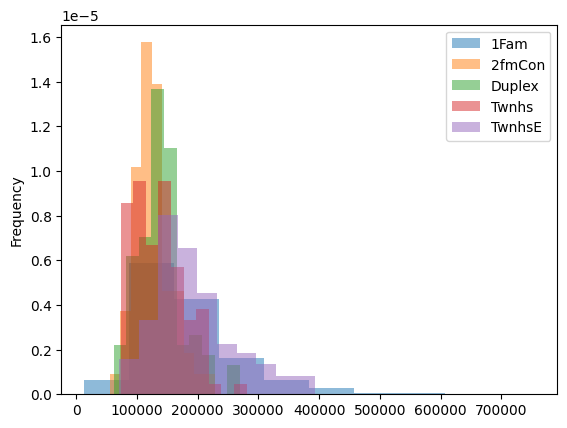

In [8]:
df_ames.groupby("Bldg Type")["SalePrice"].plot.hist(
        density=True,
        alpha=0.5,
        legend=True
    );

Here it might be easier to compare the distributions of sale price for different building types with a density plot. We still groupby (split) by building type, but now at the apply step we want a density instead of a histogram. The code is very similar to the above (we have also added x-axis limits.)

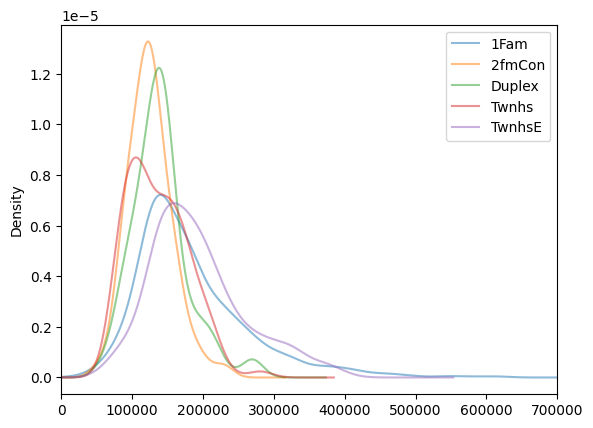

In [9]:
df_ames.groupby("Bldg Type")["SalePrice"].plot.density(
        xlim = (0, 700000),
        alpha=0.5,
        legend=True
    );

This plot allows us to visually compare the distributions. For example, we see that 1Fam and TwnhsE tend to have the highest prices, and the most variability in prices.

Compare this line of code with the code to plot a histogram of **SalePrice**:

`df_ames["SalePrice"].plot.hist(...)`.

The only difference is `.groupby("Bldg Type")`. This turns a `DataFrame` into a `DataFrameGroupBy` object, which behaves like a `DataFrame`, except that any analysis that we specify will be applied to every subset of the `DataFrame` instead of the whole `DataFrame`.

Similarly, to calculate the median sale price for each building type, we can `.groupby` the building type and then select SalePrice and calculate the median as usual.

In [10]:
median_sale_price = df_ames.groupby("Bldg Type")["SalePrice"].median()

median_sale_price

Bldg Type
1Fam      165000.0
2fmCon    122250.0
Duplex    136905.0
Twnhs     130000.0
TwnhsE    180000.0
Name: SalePrice, dtype: float64

This automatically returned the desired `Series` that we can pass to `.plot.bar()`. (It's unclear if there is a natural ordering to the categories.)

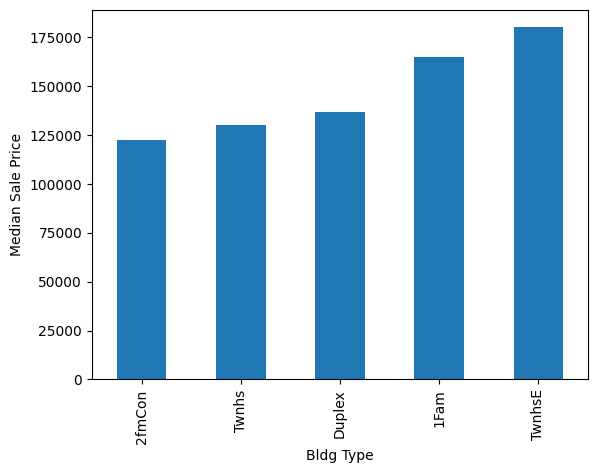

In [11]:
median_sale_price.sort_values().plot.bar(ylabel = "Median Sale Price");

It is also possible to group by more than one variable. Simply pass in a list of variable names to `.groupby()`. For example, the following code calculates the median sale price by building type and house style.

In [14]:
df_ames_group = df_ames.groupby(["Bldg Type", "House Style"])["SalePrice"].median()
df_ames_group


Bldg Type  House Style
1Fam       1.5Fin         130000.0
           1.5Unf         112750.0
           1Story         152000.0
           2.5Fin         191000.0
           2.5Unf         163500.0
           2Story         204000.0
           SFoyer         148500.0
           SLvl           165000.0
2fmCon     1.5Fin         118000.0
           1.5Unf         118000.0
           1Story         130250.0
           2.5Fin         200000.0
           2.5Unf         127950.0
           2Story         114500.0
           SFoyer         127000.0
           SLvl           140000.0
Duplex     1.5Fin         126000.0
           1Story         126000.0
           2.5Unf         183450.0
           2Story         145000.0
           SFoyer         145000.0
           SLvl           132500.0
Twnhs      1.5Fin         148400.0
           1Story         188000.0
           2Story         121000.0
           SFoyer          85250.0
           SLvl           100700.0
TwnhsE     1Story         199900

Notice that when we use `.groupby()`, the resulting index is whatever variable(s) we grouped by. Since we grouped by two variables, this index actually has two levels. An index with more than one level is called a `MultiIndex` in `pandas`. To access a particular row in a `DataFrame` that is indexed by a `MultiIndex`, we pass in a tuple of the values we want from each level.

In [15]:
df_ames.groupby(["Bldg Type", "House Style"])["SalePrice"].median()[
    ("1Fam", "2Story")
]

204000.0